In [1]:
# -------------------- Model 3: SubCorpus + CLIP --------------------
import pandas as pd
import os
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from torch.optim import AdamW 
from torch.optim.lr_scheduler import CosineAnnealingLR
from IPython.display import display
import torch.nn.functional as F
import unicodedata
from collections import Counter
import time

# Set seed for reproducibility
random.seed(985)
np.random.seed(985)
torch.manual_seed(985)

# Load the datasets and image folder
m3_train = pd.read_csv("/Users/cyq/Desktop/Dissertation/Database/SubCorpus_to_train.csv")
m3_val= pd.read_csv("/Users/cyq/Desktop/Dissertation/Database/SubCorpus_to_validation.csv")

# Define a dataset for Model 3
class ArtEmisDataset(Dataset):
    # Intialise the dataframe and CLIP precessor
    def __init__(self, df, processor): 
        self.data = df.reset_index(drop = True)
        self.processor = processor
        self.valid_idx = [i for i in range(len(self.data))
                          if os.path.exists(str(self.data.iloc[i]["PATH"]))]
    # Extract samples by rows
    def __getitem__(self, idx):
        ridx = self.valid_idx[idx]
        row = self.data.iloc[ridx] # Select the ith row from the dataframe
        path = row["PATH"] # Find the path
        text = str(row["UTTERANCE"]) if not pd.isna(row["UTTERANCE"]) else "" # Find the paired description
        # Try to open the image
        try:
            img = Image.open(path).convert("RGB")
        except Exception:
            img = Image.new("RGB", (224, 224), "white")
            print(f"Warning: Failed to load {path}, using white image")
        # Preprocess both text and image
        inputs = self.processor(text = [text], 
                                images = img, 
                                return_tensors = "pt",
                                padding = "max_length", 
                                truncation = True, 
                                max_length = 77)
        # Return a dictionary contains input_ids, attention_mask and pixel_values
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "pixel_values": inputs["pixel_values"].squeeze(0)
        }
    # Compute the length of dataset
    def __len__(self):
        return len(self.valid_idx)


# Define a function to evaluate model performance by using full-gallery retrieval
@torch.no_grad()
def evaluate_full_gallery(model, val_loader, device, topk = (1, 5, 10), chunk = 256):
    # Set the model to evaluation mode
    model.eval()
    # Create empty lists to contain all images and texts
    all_img = []
    all_txt = []
    # Loop through the validation dataloader to extract features
    for b in val_loader:
        ids = b["input_ids"].to(device)
        attn = b["attention_mask"].to(device)
        pix = b["pixel_values"].to(device)
        # Extract CLIP image and text features
        img = model.get_image_features(pix)
        txt = model.get_text_features(input_ids = ids, attention_mask = attn)
        # Normalize embeddings to unit length
        img = img / img.norm(p = 2, dim = -1, keepdim = True)
        txt = txt / txt.norm(p = 2, dim = -1, keepdim = True)
        # Add them into lists separatelt
        all_img.append(img)
        all_txt.append(txt)
    # Combine all batches into single tensors
    all_img = torch.cat(all_img, 0)
    all_txt = torch.cat(all_txt, 0)
    # Set N as the number of validation samples
    N = all_txt.size(0)
    # Get the learned logit scale
    logit_scale = model.logit_scale.exp().clamp_max(100.0)
    # Prepare to count Recall@K metrics
    max_k = max(topk)
    hits = {k:0 for k in topk} # Count of correct matches for each K
    ranks_list = [] # Create an empty list to contain the ground truth's rank position
    # Compute similarity
    for i in range(0, N, chunk):
        i_end = min(i + chunk, N)
        sims = logit_scale * (all_txt[i:i_end]@all_img.T) # Similarity matrix
        # Get the indices of top-k most similar images
        topk_idx = sims.topk(k = max_k, dim = 1).indices
        # Ground truth indices
        gt = torch.arange(i, i_end, device = sims.device)
        # Loop through to count Recall@K hits
        for k in topk:
            hits[k] += (topk_idx[:, :k] == gt.unsqueeze(1)).any(dim = 1).sum().item()
        # Compute the rank position of the ground truth image for each query
        gt_scores = sims.gather(1, gt.unsqueeze(1))
        ranks_list.append((sims >= gt_scores).sum(dim = 1).cpu())
    # Combine all rank positions
    ranks = torch.cat(ranks_list,0)
    # Calculate recall metrics
    rec = {f"R@{k}": hits[k] / float(N) for k in topk}
    rec["top1"] = rec["R@1"]
    rec["median_rank"] = ranks.median().item()
    rec["mean_rank"] = ranks.float().mean().item()
    return rec

# Define a function to evaluate model performance by using in-batch retrieval
@torch.no_grad()
def evaluate_in_batch(model, loader, device, topk = (1, 5, 10)):
    # Put the model in evaluation mode
    model.eval()
    # Initialize counters for the number of correct matches at each K value
    hits = {k: 0 for k in topk}
    # Total number of samples evaluated start from 0
    total = 0
    # Loop through each batch
    for b in loader:
        # Move text and image inputs to device
        ids = b["input_ids"].to(device)
        attn = b["attention_mask"].to(device)
        pix = b["pixel_values"].to(device)
        # Extract image and text embeddings and normalize embeddings to unit length
        img = F.normalize(model.get_image_features(pixel_values = pix), dim = -1)
        txt = F.normalize(model.get_text_features(input_ids = ids, attention_mask = attn), dim = -1)
        # Compute similarity matrix between texts and images within the same batch
        S = model.logit_scale.exp().clamp_max(100.0) * (txt @ img.T)
        # Get the maximum K value to optimize computation
        maxk_req = max(topk)
        maxk_eff = min(maxk_req, S.size(1))
        # Use topk to get indices of most similar images
        topk_idx = S.topk(k = maxk_eff, dim = 1).indices
        # Ground truth labels, each text should match the image at the same index
        labels = torch.arange(S.size(0), device = device)
        # Calculate the number of hits for each K value
        for k in topk:
            kk = min(k, S.size(1))
            hits[k] += (topk_idx[:, :kk] == labels.unsqueeze(1)).any(dim = 1).sum().item()
        # Update total number of evaluated samples
        total += S.size(0)
    return {f"Top@{k}": hits[k] / max(total, 1) for k in topk}

# Set processor, model and device
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast = False)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using", device)
model.to(device) # Move model's parameters to the device
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parameters size: total = {total_params / 1e6:.2f}M, trainable = {trainable_params / 1e6:.2f}M")

# Set dataloader, optimizer and scheduler
m3_train_loader = DataLoader(ArtEmisDataset(m3_train, processor), 
                             batch_size = 16, 
                             shuffle = True,
                             num_workers = 0,
                             persistent_workers = False)
m3_val_loader = DataLoader(ArtEmisDataset(m3_val, processor), 
                           batch_size = 16,
                           shuffle = False,
                           num_workers = 0,
                           persistent_workers = False)
optimizer = AdamW(model.parameters(), lr = 5e-5, weight_decay = 0.01)
scheduler = CosineAnnealingLR(optimizer, T_max = 20, eta_min = 5e-7)
run_start = time.time()
train_set_size = len(m3_train_loader.dataset)
val_set_size = len(m3_val_loader.dataset)
total_time = 0.0

# Define a directory to contain model
out_dir = "/Users/cyq/Desktop/Dissertation/Database/m3_clip_trained"
os.makedirs(out_dir, exist_ok = True) # Create the folder if it does not exist
cp_path = os.path.join(out_dir, "checkpoint.pt") # Define the checkpoint saving path
best_cp_path = os.path.join(out_dir, "best_checkpoint.pt") # Define the best checkpoint saving path
csv_path = os.path.join(out_dir, "epoch_metrics_m3.csv") # Define the csv file saving path

# Create empty lists to contain average losses and validation accuracy
avg_losses = []
val_accs = []

# Create empty lists for full-gallery evaluation
full_top1_list = []
full_top5_list = []
full_top10_list = []

# Create empty lists for in-batch evaluation
inb_top1_list = []
inb_top5_list = []
inb_top10_list = []

# Create an empty list to contain all metrics in each epoch
epoch_logs = []

# Prepare for the early stopping
patience = 2 # Number of consecutive epochs allowed without improvement
wait = 0 # Number of consecutive epochs without improvement
best_proxy = -1.0 # Highest recorded in-batch Top@1 accuracy
best_full = -1.0 # Highest recorded full-gallery R@1 accuracy
best_epoch = 0 # Epoch number when the best full-gallery R@1 was achieved
EVAL_EVERY = 4 # Run full-gallery evaluation every N epochs to reduce computational cost
min_delta = 1e-3 # Minimum improvement in the proxy metric required to reset the patience counter

# Set the starting epoch
start_epoch = 0

# If the code running was disrupted or stopped, resume training from last checkpoint
if os.path.exists(cp_path):
    # Load the saved checkpoint
    checkpoint = torch.load(cp_path, map_location = device)
    # Restore the model weights
    model.load_state_dict(checkpoint["model_state_dict"])
    # Restore the optimizer state
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    # If the scheduler exist in the checkpoint, restore the scheduler state
    if "scheduler_state_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    # Set the next starting epoch
    start_epoch = checkpoint["epoch"] + 1
    # Restore previously recorded metrics
    avg_losses = checkpoint.get("avg_losses", [])
    val_accs = checkpoint.get("val_accs", [])
    full_top1_list = checkpoint.get("full_top1_list", [])
    full_top5_list = checkpoint.get("full_top5_list", [])
    full_top10_list = checkpoint.get("full_top10_list", [])
    inb_top1_list = checkpoint.get("inb_top1_list", [])
    inb_top5_list = checkpoint.get("inb_top5_list", [])
    inb_top10_list = checkpoint.get("inb_top10_list", [])
    # Restore epoch with best performance
    best_epoch = checkpoint.get("best_epoch", 0)
    best_full = checkpoint.get("best_val_acc", -1)
    # Print the loading state
    print(f"Loaded checkpoint from epoch {start_epoch}")

# Loop through the epoch to train the model
for epoch in range(start_epoch, 20):
    # Set the model to the train mode
    model.train()
    # Print the current epoch number
    print(f"\n Epoch: {epoch + 1} / 20")
    epoch_t0 = time.time()
    full_eval_time = 0.0
    # Total loss start with 0
    total_loss = 0
    # Iterate over the training data in batches
    for step, batch in enumerate(tqdm(m3_train_loader)):
        # Move input data to device
        ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        pix = batch["pixel_values"].to(device)
        out = model(input_ids = ids, attention_mask = attn, pixel_values = pix, return_loss = True)
        loss = out.loss # Extract the loss value from the model output
        loss.backward()
        # Clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        # Update model weights
        optimizer.step()
        # Reset gradients to 0 before the next batch
        optimizer.zero_grad()
        # Accumulate the loss for calculating the average loss later
        total_loss += loss.item()
        # Print loss every 100 steps
        if step % 100 == 0:
            print(f"Step {step}: Loss = {loss.item():.4f}")
    # Calculate the average loss and add it to the list
    avg_loss = total_loss / len(m3_train_loader)
    avg_losses.append(avg_loss)
    # Validate the model by using in-batch retrieval
    inb = evaluate_in_batch(model, m3_val_loader, device, topk = (1, 5, 10))
    proxy = inb["Top@1"] # Use as the early stopping proxy metric
    # Add in-batch recall scores into lists separately
    inb_top1_list.append(inb["Top@1"])
    inb_top5_list.append(inb["Top@5"])
    inb_top10_list.append(inb["Top@10"])
    # Check if the improvement exceeds minimum delta
    improved_proxy = proxy > best_proxy + min_delta
    # Decide whether to run a full-gallery evaluation
    do_full = improved_proxy or ((epoch % EVAL_EVERY) == 0) or ((epoch + 1) == 20)
    if do_full:
        # Run full-gallery evaluation
        t_full0 = time.time()
        rec = evaluate_full_gallery(model, m3_val_loader, device, 
                                    topk = (1, 5, 10), chunk = 128)
        full_eval_time = time.time() - t_full0
        # Add the recall scores into the list
        full_top1_list.append(rec["R@1"])
        full_top5_list.append(rec["R@5"])
        full_top10_list.append(rec["R@10"])
        # Use R@1 from full-gallery as the validation accuracy and add it into list
        val_acc = rec["R@1"]
        val_accs.append(val_acc)
        print(f"Full-gallery R@1: {rec['R@1']:.4f}, R@5: {rec['R@5']:.4f}, R@10: {rec['R@10']:.4f}")
        # Update the best full-gallery score and save checkpoint if it improved
        if val_acc > best_full + min_delta:
            best_full = val_acc
            best_epoch = epoch + 1
            # Save checkpoint with all the metrics
            torch.save({
                "epoch": epoch,
                "best_epoch": best_epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "avg_losses": avg_losses,
                "val_accs": val_accs,
                "best_val_acc": best_full,
                "full_top1_list": full_top1_list, 
                "full_top5_list": full_top5_list, 
                "full_top10_list": full_top10_list,
                "inb_top1_list": inb_top1_list, 
                "inb_top5_list": inb_top5_list, 
                "inb_top10_list": inb_top10_list
            }, best_cp_path)
            print(f"Saved Best (full) checkpoint: epoch {epoch + 1}, full-gallery R@1 = {val_acc:.4f}")
    else:
        rec = {"R@1": np.nan, "R@5": np.nan, "R@10": np.nan, "median_rank": np.nan, "mean_rank": np.nan}
        full_eval_time = float('nan')
        print(f"Skip full-gallery this epoch. In-batch Top@1: {inb['Top@1']:.4f}, Top@5: {inb['Top@5']:.4f}, Top@10: {inb['Top@10']:.4f}")
    # Step the learning rate scheduler
    scheduler.step()
    # Get the current learning rate
    cur_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch + 1}: avg_loss = {avg_loss:.4f}; in-batch Top@1 = {proxy:.4f}, lr = {cur_lr:.2e}")
    epoch_time = time.time() - epoch_t0
    throughput = train_set_size / max(epoch_time, 1e-9)
    cur_ckpt_mb = os.path.getsize(cp_path) / 1e6 if os.path.exists(cp_path) else float('nan')
    best_ckpt_mb = os.path.getsize(best_cp_path) / 1e6 if os.path.exists(best_cp_path) else float('nan')
    # Record metrics for this epoch and save them to csv
    row = {
        "epoch": epoch + 1, 
        "avg_loss": avg_loss, 
        "lr": cur_lr,
        "inb_top1": inb["Top@1"], 
        "inb_top5": inb["Top@5"], 
        "inb_top10": inb["Top@10"],
        "full_R@1": rec["R@1"], 
        "full_R@5": rec["R@5"], 
        "full_R@10": rec["R@10"],
        "full_median_rank": rec["median_rank"], 
        "full_mean_rank": rec["mean_rank"],
        "did_full_gallery": do_full,
        "epoch_time_sec": epoch_time,
        "throughput_samples_per_sec": throughput,
        "full_eval_time_sec": full_eval_time,
        "trainable_params_M": trainable_params / 1e6,
        "total_params_M": total_params / 1e6,
        "ckpt_current_MB": cur_ckpt_mb,
        "ckpt_best_MB": best_ckpt_mb
    }
    epoch_logs.append(row)
    pd.DataFrame(epoch_logs).to_csv(csv_path, index = False)
    # Decide whether to do the early stopping
    if improved_proxy: # If the proxy improves, update it
        best_proxy = proxy
        wait = 0
    else: # If not, increase the wait counter
        wait += 1
        print(f"Early stop counter: {wait} / {patience}")
    if wait >= patience: # If the wait number bigger than patience, stop training early and print the best recorded scores
        print(f"Early stopping at epoch {epoch + 1}. Best full R@1 = {best_full:.4f}, best in-batch Top@1 = {best_proxy:.4f}")
        break
    # Save all the metrics for each epoch
    torch.save({
        "epoch": epoch, 
        "best_epoch": best_epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "avg_losses": avg_losses, 
        "val_accs": val_accs,
        "best_val_acc": best_full,
        "full_top1_list": full_top1_list, 
        "full_top5_list": full_top5_list, 
        "full_top10_list": full_top10_list,
        "inb_top1_list": inb_top1_list, 
        "inb_top5_list": inb_top5_list, 
        "inb_top10_list": inb_top10_list
    }, cp_path)

total_time = time.time() - run_start
print(f"\nTotal training wall time: {total_time / 60:.1f} minutes.")


Using mps
Parameters size: total = 151.28M, trainable = 151.28M

 Epoch: 1 / 20


  0%|                                           | 1/681 [00:02<28:46,  2.54s/it]

Step 0: Loss = 1.1173


 15%|██████                                   | 101/681 [02:54<15:29,  1.60s/it]

Step 100: Loss = 1.9005


 30%|████████████                             | 201/681 [05:46<13:07,  1.64s/it]

Step 200: Loss = 1.6872


 44%|██████████████████                       | 301/681 [08:31<10:25,  1.65s/it]

Step 300: Loss = 1.6064


 59%|████████████████████████▏                | 401/681 [11:20<07:17,  1.56s/it]

Step 400: Loss = 1.6535


 74%|██████████████████████████████▏          | 501/681 [14:00<04:47,  1.60s/it]

Step 500: Loss = 2.0909


 88%|████████████████████████████████████▏    | 601/681 [16:42<02:05,  1.57s/it]

Step 600: Loss = 1.6143


100%|█████████████████████████████████████████| 681/681 [18:54<00:00,  1.67s/it]


Full-gallery R@1: 0.0120, R@5: 0.0578, R@10: 0.1299
Saved Best (full) checkpoint: epoch 1, full-gallery R@1 = 0.0120
Epoch 1: avg_loss = 1.6835; in-batch Top@1 = 0.1486, lr = 4.97e-05

 Epoch: 2 / 20


  0%|                                           | 1/681 [00:02<25:16,  2.23s/it]

Step 0: Loss = 1.1406


 15%|██████                                   | 101/681 [02:54<17:30,  1.81s/it]

Step 100: Loss = 0.9159


 30%|████████████                             | 201/681 [05:45<13:15,  1.66s/it]

Step 200: Loss = 1.5160


 44%|██████████████████                       | 301/681 [08:32<10:08,  1.60s/it]

Step 300: Loss = 1.4960


 59%|████████████████████████▏                | 401/681 [11:20<07:27,  1.60s/it]

Step 400: Loss = 1.3952


 74%|██████████████████████████████▏          | 501/681 [14:04<05:34,  1.86s/it]

Step 500: Loss = 0.6161


 88%|████████████████████████████████████▏    | 601/681 [17:03<02:25,  1.82s/it]

Step 600: Loss = 1.2007


100%|█████████████████████████████████████████| 681/681 [19:13<00:00,  1.69s/it]


Full-gallery R@1: 0.0173, R@5: 0.0743, R@10: 0.1396
Saved Best (full) checkpoint: epoch 2, full-gallery R@1 = 0.0173
Epoch 2: avg_loss = 1.1903; in-batch Top@1 = 0.1509, lr = 4.88e-05

 Epoch: 3 / 20


  0%|                                           | 1/681 [00:01<19:44,  1.74s/it]

Step 0: Loss = 0.6125


 15%|██████                                   | 101/681 [02:55<14:45,  1.53s/it]

Step 100: Loss = 1.1535


 30%|████████████                             | 201/681 [05:36<13:33,  1.70s/it]

Step 200: Loss = 1.1901


 44%|██████████████████                       | 301/681 [08:25<10:10,  1.61s/it]

Step 300: Loss = 0.6026


 59%|████████████████████████▏                | 401/681 [11:09<07:27,  1.60s/it]

Step 400: Loss = 1.0128


 74%|██████████████████████████████▏          | 501/681 [14:00<04:42,  1.57s/it]

Step 500: Loss = 0.6786


 88%|████████████████████████████████████▏    | 601/681 [16:39<02:09,  1.62s/it]

Step 600: Loss = 0.7704


100%|█████████████████████████████████████████| 681/681 [19:03<00:00,  1.68s/it]


Skip full-gallery this epoch. In-batch Top@1: 0.1456, Top@5: 0.6089, Top@10: 0.8866
Epoch 3: avg_loss = 0.8539; in-batch Top@1 = 0.1456, lr = 4.73e-05
Early stop counter: 1 / 2

 Epoch: 4 / 20


  0%|                                           | 1/681 [00:01<19:50,  1.75s/it]

Step 0: Loss = 0.4520


 15%|██████                                   | 101/681 [02:52<15:55,  1.65s/it]

Step 100: Loss = 0.2767


 30%|████████████                             | 201/681 [05:33<13:25,  1.68s/it]

Step 200: Loss = 0.6727


 44%|██████████████████                       | 301/681 [08:23<10:12,  1.61s/it]

Step 300: Loss = 0.4946


 59%|████████████████████████▏                | 401/681 [11:12<07:28,  1.60s/it]

Step 400: Loss = 0.7488


 74%|██████████████████████████████▏          | 501/681 [13:57<04:42,  1.57s/it]

Step 500: Loss = 0.4534


 88%|████████████████████████████████████▏    | 601/681 [16:38<02:14,  1.68s/it]

Step 600: Loss = 1.0067


100%|█████████████████████████████████████████| 681/681 [18:48<00:00,  1.66s/it]


Skip full-gallery this epoch. In-batch Top@1: 0.1411, Top@5: 0.5961, Top@10: 0.8731
Epoch 4: avg_loss = 0.6454; in-batch Top@1 = 0.1411, lr = 4.53e-05
Early stop counter: 2 / 2
Early stopping at epoch 4. Best full R@1 = 0.0173, best in-batch Top@1 = 0.1509

Total training wall time: 80.4 minutes.


,epoch,avg_loss,lr,inb_top1,inb_top5,inb_top10,full_R@1,full_R@5,full_R@10,full_median_rank,full_mean_rank,did_full_gallery,epoch_time_sec,throughput_samples_per_sec,full_eval_time_sec,trainable_params_M,total_params_M,ckpt_current_MB,ckpt_best_MB
0,1,1.683507,0.000050,0.148649,0.620871,0.898649,0.012012,0.057808,0.12988,104.0,197.196701,True,1219.241031,8.927685,38.097493,151.277313,151.277313,NaN,1815.815119
1,2,1.190281,0.000049,0.150901,0.616366,0.884384,0.017267,0.074324,0.13964,98.0,192.610367,True,1237.881967,8.793245,38.569627,151.277313,151.277313,1815.807129,1815.815183
2,3,0.853939,0.000047,0.145646,0.608859,0.886637,NaN,NaN,NaN,NaN,NaN,False,1185.663447,9.180514,NaN,151.277313,151.277313,1815.807193,1815.815183
3,4,0.645441,0.000045,0.141141,0.596096,0.873123,NaN,NaN,NaN,NaN,NaN,False,1171.943331,9.287992,NaN,151.277313,151.277313,1815.807193,1815.815183


Model 3 Training Summary: 
model_tag: M3_base_full
device: mps
train_rows: 10885
val_rows: 1332
batch_size: 16
epochs_run: 4
best_epoch_full_R1: 2
best_full_R1: 0.017267267267267267
total_time_min: 80.42362484931945
avg_epoch_time_sec: 1203.6824440956116
avg_throughput_sps: 9.047359111112538
trainable_params_M: 151.277313
total_params_M: 151.277313


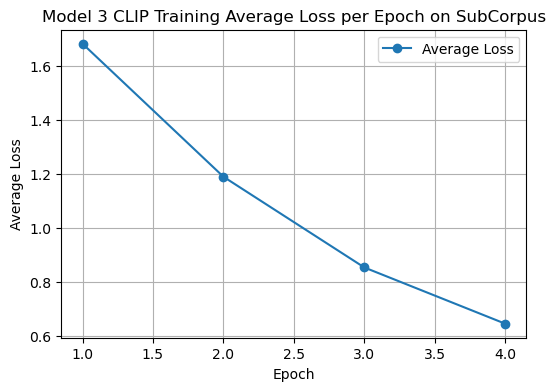

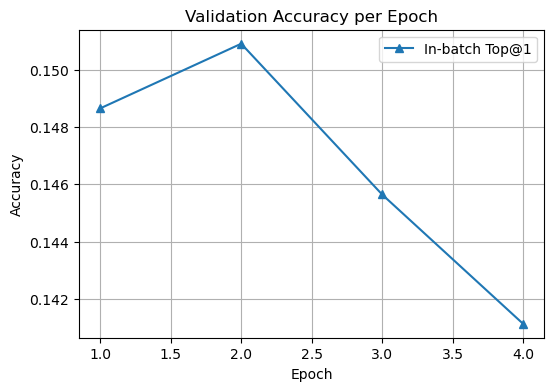

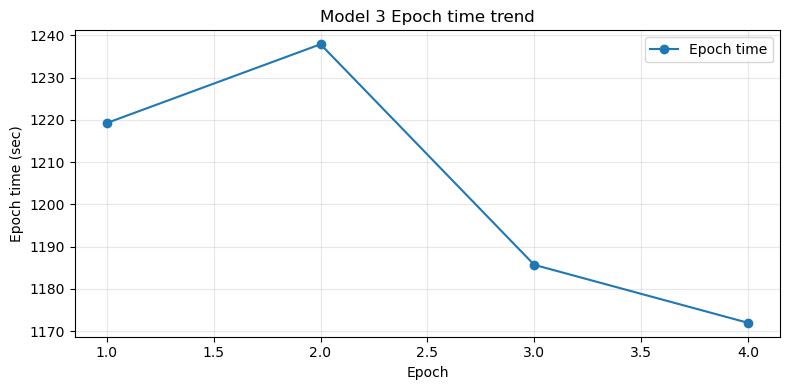


Best epoch: 2, Best full R@1: 0.0173


In [2]:
# Save results
epoch_m3 = pd.DataFrame(epoch_logs)
display(epoch_m3)
epoch_m3_path = os.path.join(out_dir, "m3_epoch_metrics.csv")
epoch_m3.to_csv(epoch_m3_path, index = False)

# Training summary
best_full_r1 = (max(full_top1_list) if len(full_top1_list) else float('nan'))
summary_row = {
    "model_tag": "M3_base_full",
    "device": device,
    "train_rows": train_set_size,
    "val_rows": val_set_size,
    "batch_size": 16,
    "epochs_run": epoch + 1,
    "best_epoch_full_R1": best_epoch,
    "best_full_R1": best_full_r1,
    "total_time_min": total_time / 60.0,
    "avg_epoch_time_sec": (np.mean([r["epoch_time_sec"] for r in epoch_logs]) if epoch_logs else float('nan')),
    "avg_throughput_sps": (np.mean([r["throughput_samples_per_sec"] for r in epoch_logs]) if epoch_logs else float('nan')),
    "trainable_params_M": trainable_params / 1e6,
    "total_params_M": total_params / 1e6,
}

# Print the training summary
print("Model 3 Training Summary: ")
for k, v in summary_row.items():
    print(f"{k}: {v}")

# Visualise the CLIP training average loss
plt.figure(figsize = (6, 4))
plt.plot(epoch_m3["epoch"],
         epoch_m3["avg_loss"],
         marker = "o",
         linestyle = "-",
         label = "Average Loss")
plt.title("Model 3 CLIP Training Average Loss per Epoch on SubCorpus")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.legend()
loss_png = os.path.join(out_dir, "loss_curve_m3.png")
plt.savefig(loss_png, dpi = 200)
plt.show()
plt.close()

# Visualise the in-batch Top@1 curve
plt.figure(figsize = (6, 4))
plt.plot(epoch_m3["epoch"],
         epoch_m3["inb_top1"],
         marker = "^",
         linestyle = "-",
         label = "In-batch Top@1")
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
acc_png = os.path.join(out_dir, "val_accuracy_m3.png")
plt.savefig(acc_png, dpi = 200)
plt.show()
plt.close()

# Visualise epoch time trend
plt.figure(figsize = (8, 4))
plt.plot(epoch_m3["epoch"], epoch_m3["epoch_time_sec"], marker = "o", linestyle = "-", label = "Epoch time")
plt.xlabel("Epoch")
plt.ylabel("Epoch time (sec)")
plt.title("Model 3 Epoch time trend")
plt.grid(True, alpha = 0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "epoch_time_trend_m3.png"), dpi = 150)
plt.show()
plt.close()

# Save the final model
final_dir = os.path.join(out_dir, "final_model")
os.makedirs(final_dir, exist_ok = True)
model.save_pretrained(final_dir)
processor.save_pretrained(final_dir)
print(f"\nBest epoch: {best_epoch}, Best full R@1: {best_full:.4f}")